In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from scipy import ndimage, optimize
from scipy.fft import fft2, ifft2
import cv2
import scipy.constants as c
import pandas as pd
from IPython.display import display

import beam_caustic


# Time of Flight Analysis

In [36]:

def load_ccd_txt(filename: str) -> np.ndarray:
    # Adjust delimiter/skiprows if needed
    return np.loadtxt(filename, dtype=np.uint8, delimiter=None, skiprows=3)


def roi_signal_sum_adu(img: np.ndarray, roi: tuple, offset_adu: float) -> float:
    """
    Sum of (img - offset) over ROI, in ADU.
    roi is expected as (x0, x1, y0, y1) with x=columns, y=rows.
    """
    x0, x1, y0, y1 = roi
    sub = img[y0:y1, x0:x1].astype(float)
    return float(np.sum(sub - offset_adu))


def run_d4sigma(
    image: np.ndarray,
    *,
    pixel_size_x_mm: float = 8.4e-3,
    pixel_size_y_mm: float = 9.8e-3,
    self_conf_width: float = 3,
    bkg_ellipse_axes_scaling: float = 1.0,
    d4s_rel_tol: float | None = None,
    d4s_abs_tol: float = 1.0,
    debug_d4sigma: bool = False,
    make_fit_plots: bool = False,
    plot_label: str = "",
):
    """
    Analyze a single CCD sub-image (e.g., before-shutter or after-shutter region).

    Returns
    -------
    fit_dict : dict
        Parameters from the 2D Gaussian fit (from beam_caustic.fit_gaussian_2d).
    gaussian_model : callable
        Callable model gaussian_2d(*popt) that can be evaluated on coordinates.
    d4sigma_summary : dict
        Key results from the D4σ method.
    """

    # ----------------------------
    # 1) Estimate background region using an ellipse fit
    # ----------------------------
    xc_ell, yc_ell, minor_saxis_ell, major_saxis_ell, orientation_ell = beam_caustic.find_ellipse(image)

    ellipse_mask = beam_caustic.get_ellipse_mask(
        xc_ell, yc_ell,
        bkg_ellipse_axes_scaling * minor_saxis_ell,
        bkg_ellipse_axes_scaling * major_saxis_ell,
        orientation_ell,
        image.shape
    )

    # Background estimate from pixels *outside* the ellipse
    if np.any(~ellipse_mask):
        bkg_avg = float(image[~ellipse_mask].mean())
    else:
        # Fallback: if ellipse covers everything, assume zero background
        bkg_avg = 0.0

    image_bkg_corr = image.astype(float) - bkg_avg

    # ----------------------------
    # 2) Fit a 2D Gaussian (for center + waist estimates)
    # ----------------------------
    fit_result, fit_dict, gaussian_2d = beam_caustic.fit_gaussian_2d(
        image_bkg_corr,
        pstart=[
            image_bkg_corr.max(),
            xc_ell, yc_ell,
            minor_saxis_ell, major_saxis_ell,
            orientation_ell,
            0.0
        ],
    )

    # Convert (w0x, w0y) [pixels] -> 1/e^2 diameters in mm (matching your original)
    w_major_mm = 2 * fit_dict["w0x_Value"] * pixel_size_x_mm
    w_minor_mm = 2 * fit_dict["w0y_Value"] * pixel_size_y_mm

    # ----------------------------
    # 3) Run D4σ method (for ISO-style beam widths)
    # ----------------------------
    xc_d4s, yc_d4s, dx_d4s, dy_d4s, orientation_d4s, iterations_d4s, converged_d4s = (
        beam_caustic.run_d4sigma_method(
            image_bkg_corr,
            self_conf_width=self_conf_width,
            debug=debug_d4sigma,
            ignore_crop_error=True,
            rel_tol=d4s_rel_tol,
            abs_tol=d4s_abs_tol,
        )
    )

    d4sigma_summary = {
        "x0_px": float(xc_d4s),
        "y0_px": float(yc_d4s),
        "D4sigma_x_px": float(dx_d4s),
        "D4sigma_y_px": float(dy_d4s),
        "phi_deg": float(orientation_d4s),
        "iterations": int(iterations_d4s),
        "converged": bool(converged_d4s),
        "bkg_avg_cts": float(bkg_avg),
    }

    # ----------------------------
    # 4) Optional: diagnostic plots for this sub-image
    # ----------------------------
    if make_fit_plots:
        fig, axs = plt.subplots(1, 3, figsize=(14, 3.5), constrained_layout=True)
        fig.suptitle(f"2D Gaussian fit diagnostics {plot_label}".strip())

        image_fit = gaussian_2d(*fit_result["Popt"])(*np.flipud(np.indices(image_bkg_corr.shape)))
        images = [
            (image_bkg_corr, "Background-corrected"),
            (image_fit, "Gaussian fit"),
            (image_fit - image_bkg_corr, "Residual (fit - data)"),
        ]

        for ax, (im, title) in zip(axs, images):
            h = ax.imshow(im, cmap="gray")
            ax.set_title(title)
            ax.set_xlabel("x (px)")
            ax.set_ylabel("y (px)")
            plt.colorbar(h, ax=ax, fraction=0.046, pad=0.04)

        # Add a small text box with key numbers
        text = (
            f"x0={fit_dict['x0_Value']:.2f} px, y0={fit_dict['y0_Value']:.2f} px\n"
            f"w_major={w_major_mm:.3e} mm, w_minor={w_minor_mm:.3e} mm\n"
            f"D4σx={dx_d4s:.2f} px, D4σy={dy_d4s:.2f} px, converged={converged_d4s}"
        )
        axs[2].text(1.02, 0.5, text, transform=axs[2].transAxes, va="center")

    # Return raw fit dict + model, plus a compact D4σ summary
    return fit_dict, gaussian_2d, d4sigma_summary





def clip_roi(x0, x1, y0, y1, nx, ny, min_size=8):
    x0 = int(np.clip(x0, 0, nx-1))
    x1 = int(np.clip(x1, 1, nx))
    y0 = int(np.clip(y0, 0, ny-1))
    y1 = int(np.clip(y1, 1, ny))
    if (x1 - x0) < min_size or (y1 - y0) < min_size:
        return None
    return x0, x1, y0, y1

def safe_moments_ellipse_params(img, bg=None, min_total=1e3):
    im = np.asarray(img, float)

    if bg is None:
        bg = np.quantile(im, 0.2)

    w = np.clip(im - bg, 0, None)
    total = w.sum()
    if total < min_total:
        raise ValueError("Not enough signal for stable moments.")

    yy, xx = np.indices(w.shape)
    xc = (w * xx).sum() / total
    yc = (w * yy).sum() / total

    x = xx - xc
    y = yy - yc

    mxx = (w * x * x).sum() / total
    myy = (w * y * y).sum() / total
    mxy = (w * x * y).sum() / total

    C = np.array([[mxx, mxy],
                  [mxy, myy]], dtype=float)

    evals, evecs = np.linalg.eigh(C)
    if np.any(~np.isfinite(evals)) or np.min(evals) <= 0:
        raise ValueError(f"Invalid covariance eigenvalues: {evals}")

    sig1, sig2 = np.sqrt(evals[1]), np.sqrt(evals[0])
    v1 = evecs[:, 1]
    theta = float(np.arctan2(v1[1], v1[0]))
    return float(xc), float(yc), float(sig1), float(sig2), theta

def fallback_roi_from_peak(img, halfsize=80):
    im = np.asarray(img, float)
    ny, nx = im.shape
    y0, x0 = np.unravel_index(np.argmax(im), im.shape)
    x1 = int(np.clip(x0 - halfsize, 0, nx-1))
    x2 = int(np.clip(x0 + halfsize, 1, nx))
    y1 = int(np.clip(y0 - halfsize, 0, ny-1))
    y2 = int(np.clip(y0 + halfsize, 1, ny))
    if (x2-x1) < 8 or (y2-y1) < 8:
        raise ValueError("Fallback ROI degenerate.")
    return x1, x2, y1, y2

def run_d4sigma_safe(img, *, roi_sigma_mult=6.0, roi_pad_px=30, roi_min_size=16, peak_halfsize=80,
                     make_fit_plots=False, plot_label=""):
    """
    Robust wrapper:
      1) moments-derived ROI; if invalid -> fallback ROI around peak
      2) run_d4sigma on ROI
      3) shift x0/y0 back into full-image coords
    Returns: (fit_dict, gaussian_model, d4sigma_summary, meta)
    """
    im = np.asarray(img, float)
    ny, nx = im.shape
    used_fallback = False

    try:
        xc, yc, sigx, sigy, _theta = safe_moments_ellipse_params(im)
        rx = int(np.ceil(roi_sigma_mult * sigx + roi_pad_px))
        ry = int(np.ceil(roi_sigma_mult * sigy + roi_pad_px))
        roi = clip_roi(int(xc - rx), int(xc + rx), int(yc - ry), int(yc + ry), nx, ny, min_size=roi_min_size)
        if roi is None:
            raise ValueError("Moments ROI degenerate.")
        x1, x2, y1, y2 = roi
    except Exception:
        used_fallback = True
        x1, x2, y1, y2 = fallback_roi_from_peak(im, halfsize=peak_halfsize)

    sub = im[y1:y2, x1:x2]
    fit_dict, gaussian_model, d4sigma_summary = run_d4sigma(
        sub,
        make_fit_plots=make_fit_plots,
        plot_label=plot_label,
    )

    # Shift center from subimage coords -> full-image coords
    fit_dict = dict(fit_dict)  # copy in case original is immutable
    fit_dict["x0_Value"] = float(fit_dict["x0_Value"]) + x1
    fit_dict["y0_Value"] = float(fit_dict["y0_Value"]) + y1

    meta = {"roi": (x1, x2, y1, y2), "used_fallback_roi": used_fallback}
    return fit_dict, gaussian_model, d4sigma_summary, meta


In [28]:
def get_params_old(filename: str, *, show_raw: bool = False, show_split: bool = True, make_fit_plots: bool = False):
    """
    Load a CCD text file, split into before/after shutter halves, and analyze both regions.

    Returns
    -------
    results : dict
        Contains per-region fit outputs and a small summary table.
    """
    fname = Path(filename).name

    # ---- Load CCD array (your file format: 3 header rows, then pixel values)
    pixel_array = np.loadtxt(filename, dtype=np.uint8, delimiter=None, skiprows=3)

    if show_raw:
        plt.figure(figsize=(6, 4))
        h = plt.imshow(pixel_array, cmap="gray", vmin=0, vmax=255)
        plt.colorbar(h, fraction=0.046, pad=0.04)
        plt.title(f"Raw CCD Image: {fname}")
        plt.xlabel("x (px)")
        plt.ylabel("y (px)")
        plt.show()

    # ---- Split into two halves (matching your original indexing)
    # Image shape seems to be (492, 384). You were taking:
    #   before_shutter: bottom half
    #   after_shutter:  top half
    ny, nx = pixel_array.shape
    mid = ny // 2

    after_shutter = pixel_array[0:mid-1, 0:nx]          # top half
    before_shutter = pixel_array[mid+1:ny-1, 0:nx]      # bottom half

    if show_split:
        fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), constrained_layout=True)
        fig.suptitle(f"CCD halves: {fname}")

        # Keep the same scaling for easy comparison
        vmin, vmax = 0, 255
        h0 = axs[0].imshow(before_shutter, cmap="gray", vmin=vmin, vmax=vmax)
        axs[0].set_title(f"Before Shutter: {fname}")
        axs[0].set_xlabel("x (px)")
        axs[0].set_ylabel("y (px)")

        h1 = axs[1].imshow(after_shutter, cmap="gray", vmin=vmin, vmax=vmax)
        axs[1].set_title(f"After Shutter: {fname}")
        axs[1].set_xlabel("x (px)")
        axs[1].set_ylabel("y (px)")

        # One shared colorbar (matches the common scale)
        cbar = fig.colorbar(h1, ax=axs, fraction=0.046, pad=0.04)
        cbar.set_label("Counts (cts/px)")
        plt.show()

    # ---- Analyze each region
    regions = {
        "before_shutter": before_shutter,
        "after_shutter": after_shutter,
    }

    outputs = {}
    rows = []

    for region_name, region_img in regions.items():
        fit_dict, gaussian_model, d4sigma_summary = run_d4sigma(
            region_img,
            make_fit_plots=make_fit_plots,
            plot_label=f"({region_name}) {fname}",
        )

        # 1/e^2 diameter (mm), matching your earlier calculation
        pixel_size_x_mm = 8.4e-3
        pixel_size_y_mm = 9.8e-6
        waist_x_mm = 2 * fit_dict["w0x_Value"] * pixel_size_x_mm
        waist_y_mm = 2 * fit_dict["w0y_Value"] * pixel_size_y_mm

        outputs[region_name] = {
            "fit_dict": fit_dict,
            "gaussian_model": gaussian_model,
            "d4sigma": d4sigma_summary,
            "waist_x_mm": float(waist_x_mm),
            "waist_y_mm": float(waist_y_mm),
        }

        rows.append({
            "file": fname,
            "region": region_name,
            "x0_px": fit_dict["x0_Value"],
            "y0_px": fit_dict["y0_Value"],
            "waist_x_mm (2*w0x*px)": waist_x_mm,
            "waist_y_mm (2*w0y*py)": waist_y_mm,
            "D4sigma_x_px": d4sigma_summary["D4sigma_x_px"],
            "D4sigma_y_px": d4sigma_summary["D4sigma_y_px"],
            "phi_deg": d4sigma_summary["phi_deg"],
            "bkg_avg_cts": d4sigma_summary["bkg_avg_cts"],
            "d4sigma_converged": d4sigma_summary["converged"],
        })

    summary_df = pd.DataFrame(rows)

    return {
        "file": fname,
        "pixel_array": pixel_array,
        "regions": outputs,
        "summary_df": summary_df,
    }


In [29]:
def get_params(
    filename: str,
    *,
    show_raw: bool = False,
    show_split: bool = True,
    make_fit_plots: bool = False,
    # camera pixel pitches (meters) on the sensor:
    pixel_pitch_x_m: float = 8.4e-6,
    pixel_pitch_y_m: float = 9.8e-6,
    magnification: float = 0.5,          # image size on sensor / object size (adjust to your definition)
):
    """
    Load a CCD text file, split into before/after shutter halves, and analyze both regions robustly.

    Returns
    -------
    results : dict
        Contains per-region fit outputs and a small summary table.
    """
    fname = Path(filename).name

    # ---- Load CCD array (3 header rows, then pixel values)
    pixel_array = np.loadtxt(filename, dtype=np.uint8, delimiter=None, skiprows=3)

    if show_raw:
        plt.figure(figsize=(6, 4))
        h = plt.imshow(pixel_array, cmap="gray", vmin=0, vmax=255)
        plt.colorbar(h, fraction=0.046, pad=0.04)
        plt.title(f"Raw CCD Image: {fname}")
        plt.xlabel("x (px)")
        plt.ylabel("y (px)")
        plt.show()

    # ---- Split into halves (matching your original indexing)
    ny, nx = pixel_array.shape
    mid = ny // 2

    after_shutter  = pixel_array[0:mid-1, 0:nx].astype(float)      # top half
    before_shutter = pixel_array[mid+1:ny-1, 0:nx].astype(float)   # bottom half

    if show_split:
        fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), constrained_layout=True)
        fig.suptitle(f"CCD halves: {fname}")

        vmin, vmax = 0, 255
        axs[0].imshow(before_shutter, cmap="gray", vmin=vmin, vmax=vmax)
        axs[0].set_title(f"Before Shutter: {fname}")
        axs[0].set_xlabel("x (px)")
        axs[0].set_ylabel("y (px)")

        h1 = axs[1].imshow(after_shutter, cmap="gray", vmin=vmin, vmax=vmax)
        axs[1].set_title(f"After Shutter: {fname}")
        axs[1].set_xlabel("x (px)")
        axs[1].set_ylabel("y (px)")

        cbar = fig.colorbar(h1, ax=axs, fraction=0.046, pad=0.04)
        cbar.set_label("Counts (cts/px)")
        plt.show()

    # ---- meters-per-pixel in object plane (anisotropic)
    # If magnification is defined differently in your setup, adjust accordingly.
    px_to_mx = pixel_pitch_x_m / magnification
    px_to_my = pixel_pitch_y_m / magnification
    px_to_mx_mm = px_to_mx * 1e3
    px_to_my_mm = px_to_my * 1e3

    regions = {
        "before_shutter": before_shutter,
        "after_shutter": after_shutter,
    }

    outputs = {}
    rows = []

    for region_name, region_img in regions.items():
        fit_dict, gaussian_model, d4sigma_summary, meta = run_d4sigma_safe(
            region_img,
            make_fit_plots=make_fit_plots,
            plot_label=f"({region_name}) {fname}",
        )

        # 1/e^2 diameter in mm: diameter = 2*w0
        waist_x_mm = 2.0 * float(fit_dict["w0x_Value"]) * px_to_mx_mm
        waist_y_mm = 2.0 * float(fit_dict["w0y_Value"]) * px_to_my_mm

        outputs[region_name] = {
            "fit_dict": fit_dict,
            "gaussian_model": gaussian_model,
            "d4sigma": d4sigma_summary,
            "waist_x_mm": float(waist_x_mm),
            "waist_y_mm": float(waist_y_mm),
            "roi": meta["roi"],
            "used_fallback_roi": meta["used_fallback_roi"],
            "px_to_mx": float(px_to_mx),
            "px_to_my": float(px_to_my),
            "magnification": float(magnification),
        }

        rows.append({
            "file": fname,
            "region": region_name,
            "x0_px": float(fit_dict["x0_Value"]),
            "y0_px": float(fit_dict["y0_Value"]),
            "waist_x_mm (2*w0x*px)": float(waist_x_mm),
            "waist_y_mm (2*w0y*py)": float(waist_y_mm),
            "D4sigma_x_px": d4sigma_summary.get("D4sigma_x_px", np.nan),
            "D4sigma_y_px": d4sigma_summary.get("D4sigma_y_px", np.nan),
            "phi_deg": d4sigma_summary.get("phi_deg", np.nan),
            "bkg_avg_cts": d4sigma_summary.get("bkg_avg_cts", np.nan),
            "d4sigma_converged": d4sigma_summary.get("converged", False),
            "roi": meta["roi"],
            "used_fallback_roi": meta["used_fallback_roi"],
        })

    summary_df = pd.DataFrame(rows)

    return {
        "file": fname,
        "pixel_array": pixel_array,
        "regions": outputs,
        "summary_df": summary_df,
    }


In [30]:
def analyze_tof_old(tof_s: float, filename: str, *, make_fit_plots: bool = False, show_split: bool = True):
    """
    Compute TOF velocity and a (simple) temperature estimate from before/after shutter positions.

    Parameters
    ----------
    tof_s : float
        Time-of-flight in seconds.
    filename : str
        CCD file to analyze.
    make_fit_plots : bool
        If True, show Gaussian fit diagnostics per region.
    show_split : bool
        If True, show a side-by-side imshow of before vs after shutter.

    Returns
    -------
    results : dict
        vx, vy, Tx, Ty plus a compact per-file summary table.
    """
    out = get_params(filename, show_raw=False, show_split=show_split, make_fit_plots=make_fit_plots)

    # Pull out fitted centers (convert px -> meters using the same factor you had: *1e-3)
    # NOTE: If you have a more accurate px->meter conversion, swap it in here.

    pixel_size_x_mm = 8.4e-3
    pixel_size_y_mm = 9.8e-6

    before = out["regions"]["before_shutter"]["fit_dict"]
    after  = out["regions"]["after_shutter"]["fit_dict"]



    x_init_m  = before["x0_Value"] * 1e-3
    x_final_m = after["x0_Value"]  * 1e-3
    y_init_m  = before["y0_Value"] * 1e-3
    y_final_m = after["y0_Value"]  * 1e-3

    # waist_x_init = before['w0x_Value'] * 2 * pixel_size_x_mm * 1e-3
    # waist_y_init = before['w0y_Value'] * 2 * pixel_size_y_mm * 1e-3
    # waist_x_final = after["w0x_Value"] * 2 * pixel_size_x_mm * 1e-3
    # waist_y_final = after["w0y_Value"] * 2 * pixel_size_y_mm * 1e-3


    waist_x_init = out["regions"]["before_shutter"]['waist_x_mm'] * 2 * 1e-3
    waist_y_init = out["regions"]["before_shutter"]['waist_y_mm'] * 2 * 1e-3
    waist_x_final = out["regions"]["after_shutter"]['waist_x_mm'] * 2 * 1e-3
    waist_y_final = out["regions"]["after_shutter"]['waist_y_mm'] * 2 * 1e-3
    
    vx = (x_final_m - x_init_m) / tof_s
    vy = (y_final_m - y_init_m) / tof_s

    # Temperature estimate (keeping your original structure; adjust if you have a specific model)
    m_rb85 = 85 * c.atomic_mass
    Tx = m_rb85 * (waist_x_final**2 - waist_x_init**2) / (3 * c.k * tof_s**2)
    Ty = m_rb85 * (waist_y_final**2 - waist_y_init**2) / (3 * c.k * tof_s**2)

    # Nicely formatted per-file printout
    fname = Path(filename).name
    pretty = pd.DataFrame([{
        "file": fname,
        "tof (ms)": tof_s * 1e3,
        "vx (m/s)": vx,
        "vy (m/s)": vy,
        "Tx (uK)": Tx*1e6,
        "Ty (uK)": Ty*1e6,
    }])

    display(pretty.style.format({
        "tof (ms)": "{:.3f}",
        "vx (m/s)": "{:.3e}",
        "vy (m/s)": "{:.3e}",
        "Tx (uK)": "{:.3e}",
        "Ty (uK)": "{:.3e}",
    }))

    return {
        "file": fname,
        "vx": float(vx),
        "vy": float(vy),
        "Tx": float(Tx),
        "Ty": float(Ty),
        "fit_summary": out["summary_df"],
    }


In [31]:

def analyze_tof(
    tof_s: float,
    filename: str,
    *,
    make_fit_plots: bool = False,
    show_split: bool = True,
    # pass-through calibration params to get_params:
    pixel_pitch_x_m: float = 8.4e-6,
    pixel_pitch_y_m: float = 9.8e-6,
    magnification: float = 0.5,
):
    """
    Compute TOF velocity and a simple temperature estimate from before/after shutter fits.

    Uses anisotropic calibration:
      x [m] = x0_px * (pixel_pitch_x_m / magnification)
      y [m] = y0_px * (pixel_pitch_y_m / magnification)

    Temperature model (same structure you had):
      T = (m / (3 k)) * (w_f^2 - w_i^2) / tof^2
    where w is the 1/e^2 diameter in meters (from get_params).
    """
    out = get_params(
        filename,
        show_raw=False,
        show_split=show_split,
        make_fit_plots=make_fit_plots,
        pixel_pitch_x_m=pixel_pitch_x_m,
        pixel_pitch_y_m=pixel_pitch_y_m,
        magnification=magnification,
    )

    before = out["regions"]["before_shutter"]["fit_dict"]
    after  = out["regions"]["after_shutter"]["fit_dict"]

    # meters-per-pixel in object plane (anisotropic)
    px_to_mx = out["regions"]["before_shutter"]["px_to_mx"]
    px_to_my = out["regions"]["before_shutter"]["px_to_my"]

    # Centers in meters
    x_init_m  = float(before["x0_Value"]) * px_to_mx
    x_final_m = float(after["x0_Value"])  * px_to_mx
    y_init_m  = float(before["y0_Value"]) * px_to_my
    y_final_m = float(after["y0_Value"])  * px_to_my

    # Waists from get_params are ALREADY 1/e^2 diameters in mm
    waist_x_init_m  = float(out["regions"]["before_shutter"]["waist_x_mm"]) * 1e-3
    waist_y_init_m  = float(out["regions"]["before_shutter"]["waist_y_mm"]) * 1e-3
    waist_x_final_m = float(out["regions"]["after_shutter"]["waist_x_mm"])  * 1e-3
    waist_y_final_m = float(out["regions"]["after_shutter"]["waist_y_mm"])  * 1e-3

    # Velocities
    vx = (x_final_m - x_init_m) / tof_s
    vy = (y_final_m - y_init_m) / tof_s

    # Temperatures
    m_rb85 = 85 * c.atomic_mass
    pref = m_rb85 / (3 * c.k)

    Tx = pref * (waist_x_final_m**2 - waist_x_init_m**2) / (tof_s**2)
    Ty = pref * (waist_y_final_m**2 - waist_y_init_m**2) / (tof_s**2)

    # Pretty table
    fname = Path(filename).name
    pretty = pd.DataFrame([{
        "file": fname,
        "tof (ms)": tof_s * 1e3,
        "vx (m/s)": vx,
        "vy (m/s)": vy,
        "Tx (uK)": Tx * 1e6,
        "Ty (uK)": Ty * 1e6,
        "roi_before": out["regions"]["before_shutter"]["roi"],
        "roi_after":  out["regions"]["after_shutter"]["roi"],
        "fallback_before": out["regions"]["before_shutter"]["used_fallback_roi"],
        "fallback_after":  out["regions"]["after_shutter"]["used_fallback_roi"],
    }])

    display(pretty.style.format({
        "tof (ms)": "{:.3f}",
        "vx (m/s)": "{:.3e}",
        "vy (m/s)": "{:.3e}",
        "Tx (uK)": "{:.3e}",
        "Ty (uK)": "{:.3e}",
    }))

    return {
        "file": fname,
        "tof_s": float(tof_s),
        "px_to_mx": float(px_to_mx),
        "px_to_my": float(px_to_my),
        "vx": float(vx),
        "vy": float(vy),
        "Tx": float(Tx),
        "Ty": float(Ty),
        "fit_summary": out["summary_df"],
        "regions": out["regions"],
    }


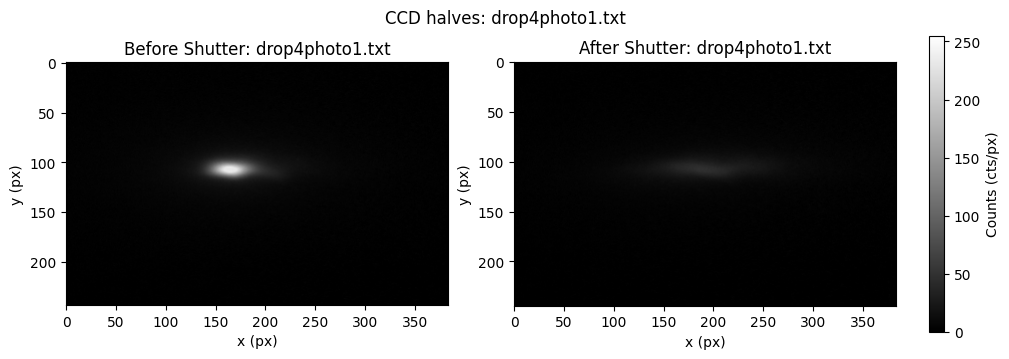

Error: Unable to determine beam parameters using moments, stopping


/Users/nadiathesun/Downloads/adinadia12826 MOT data/Physics111B/ccd analysis/beam_caustic.py:170: RuntimeWarning: invalid value encountered in sqrt
  dx = 2*np.sqrt(2)*np.sqrt(xx+yy+(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))
/Users/nadiathesun/Downloads/adinadia12826 MOT data/Physics111B/ccd analysis/beam_caustic.py:171: RuntimeWarning: invalid value encountered in sqrt
  dy = 2*np.sqrt(2)*np.sqrt(xx+yy-(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))


Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK),roi_before,roi_after,fallback_before,fallback_after
0,drop4photo1.txt,10.000,4.807e-02,-2.287e-03,4.178e+02,1.678e+01,"(0, 384, 0, 244)","(0, 384, 0, 245)",False,False


,file,region,x0_px,y0_px,waist_x_mm (2*w0x*px),waist_y_mm (2*w0y*py),D4sigma_x_px,D4sigma_y_px,phi_deg,bkg_avg_cts,d4sigma_converged,roi,used_fallback_roi
0,drop4photo1.txt,before_shutter,165.20,107.03,1.137e+00,4.754e-01,nan,nan,24.42,2.71,False,"(0, 384, 0, 244)",False
1,drop4photo1.txt,after_shutter,193.82,105.87,3.682e+00,8.476e-01,188.44,nan,-3.52,1.45,False,"(0, 384, 0, 245)",False


In [7]:
# --- Single-file example
filename = "drop4photo1.txt"
res = analyze_tof(10e-3, filename, make_fit_plots=False, show_split=True)

# Show per-region fit summary for this file
display(res["fit_summary"].style.format({
    "x0_px": "{:.2f}",
    "y0_px": "{:.2f}",
    "waist_x_mm (2*w0x*px)": "{:.3e}",
    "waist_y_mm (2*w0y*py)": "{:.3e}",
    "D4sigma_x_px": "{:.2f}",
    "D4sigma_y_px": "{:.2f}",
    "phi_deg": "{:.2f}",
    "bkg_avg_cts": "{:.2f}",
}))


---


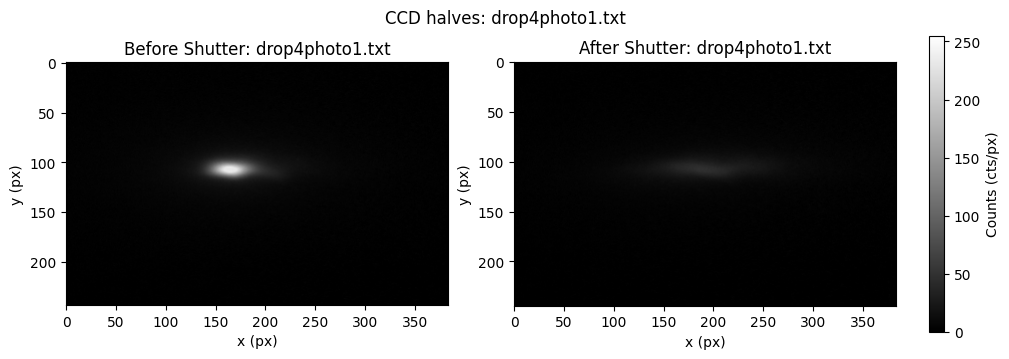

Error: Unable to determine beam parameters using moments, stopping


/Users/nadiathesun/Downloads/adinadia12826 MOT data/Physics111B/ccd analysis/beam_caustic.py:170: RuntimeWarning: invalid value encountered in sqrt
  dx = 2*np.sqrt(2)*np.sqrt(xx+yy+(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))
/Users/nadiathesun/Downloads/adinadia12826 MOT data/Physics111B/ccd analysis/beam_caustic.py:171: RuntimeWarning: invalid value encountered in sqrt
  dy = 2*np.sqrt(2)*np.sqrt(xx+yy-(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))


Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK),roi_before,roi_after,fallback_before,fallback_after
0,drop4photo1.txt,10.000,4.807e-02,-2.287e-03,4.178e+02,1.678e+01,"(0, 384, 0, 244)","(0, 384, 0, 245)",False,False


In [8]:
params_dict = analyze_tof(10e-3, filename)

In [9]:
# --- Batch analysis across multiple files
filenames = ["drop4photo1.txt", "drop5photo1.txt", "droppic2.txt"]

batch_rows = []
for fn in filenames:
    r = analyze_tof(10e-3, fn, make_fit_plots=False, show_split=False)  # no plots in batch
    batch_rows.append({k: r[k] for k in ["file", "vx", "vy", "Tx", "Ty"]})

batch_df = pd.DataFrame(batch_rows)

display(batch_df.style.format({
    "vx": "{:.3e}",
    "vy": "{:.3e}",
    "Tx": "{:.3e}",
    "Ty": "{:.3e}",
}))


Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK),roi_before,roi_after,fallback_before,fallback_after
0,drop4photo1.txt,10.000,4.807e-02,-2.287e-03,4.178e+02,1.678e+01,"(0, 384, 0, 244)","(0, 384, 0, 245)",False,False


Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK),roi_before,roi_after,fallback_before,fallback_after
0,drop5photo1.txt,10.000,4.027e-02,-1.797e-03,2.105e+02,7.467e+00,"(0, 384, 0, 244)","(0, 384, 0, 245)",False,False


Error: Unable to determine beam parameters using moments, stopping


,file,tof (ms),vx (m/s),vy (m/s),Tx (uK),Ty (uK),roi_before,roi_after,fallback_before,fallback_after
0,droppic2.txt,10.000,6.833e-02,-9.054e-03,2.022e+02,8.694e+00,"(0, 384, 0, 211)","(0, 384, 4, 200)",False,False


,file,vx,vy,Tx,Ty
0,drop4photo1.txt,4.807e-02,-2.287e-03,4.178e-04,1.678e-05
1,drop5photo1.txt,4.027e-02,-1.797e-03,2.105e-04,7.467e-06
2,droppic2.txt,6.833e-02,-9.054e-03,2.022e-04,8.694e-06


## Atom number (calibration)

The 2D Gaussian fit gives a total camera signal  (in “camera counts”), not atoms by itself.
The most robust way to convert to atom number in this lab is to calibrate the camera integral to PD3:

1. For each image, compute a background-subtracted “Gaussian integral” $S_{\rm cam}$ from the fit.
2. For the same shot/time, compute the PD3 atom number $N_{\rm PD}$ from your voltage analysis.
3. Fit a line $N_{\rm PD} \approx \alpha S_{\rm cam} + \beta$ (often $\beta\approx 0$ if background subtraction is good).
4. Use $N \approx \alpha S_{\rm cam} + \beta$ to get atoms from camera images.

This avoids needing camera QE, gain, exact optics transmission, etc. All of that lives in $\alpha$.


In [10]:
import numpy as np

def gaussian_integral_from_fitdict(fit_dict: dict, *, subtract_offset: bool = True) -> float:
    """
    Returns the integrated Gaussian signal in 'camera units' (counts * pixels^2),
    using the 2D Gaussian model parameters from your fit_dict.

    Assumes model form:
        I(x,y) = Offset + Amplitude * exp( ... )
    with widths w0x, w0y (in pixels).

    Integral of Gaussian part (no offset):
        S = Amplitude * (2*pi*w0x*w0y)
    """
    # Required keys from your fitter output
    A = float(fit_dict["Amplitude_Value"])
    sx = float(fit_dict["w0x_Value"])
    sy = float(fit_dict["w0y_Value"])

    S = A * (2.0 * np.pi * sx * sy)

    # NOTE: subtract_offset doesn't change S here because we're integrating only the Gaussian term.
    # Offset subtraction matters if you instead integrate the *full image* over an ROI.
    return S


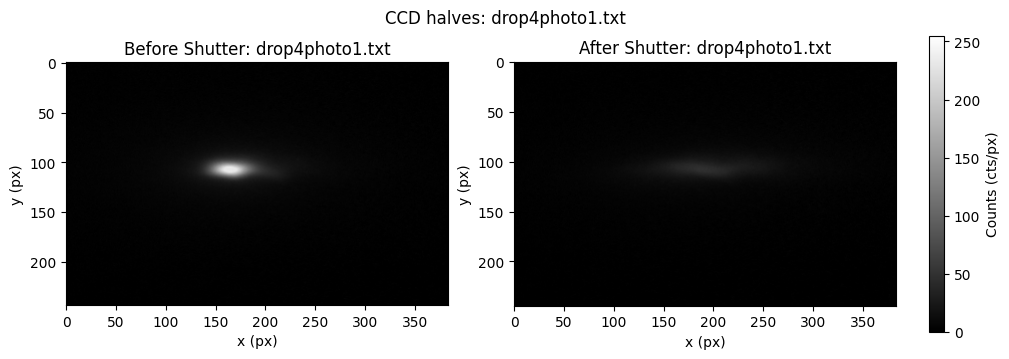

Error: Unable to determine beam parameters using moments, stopping


/Users/nadiathesun/Downloads/adinadia12826 MOT data/Physics111B/ccd analysis/beam_caustic.py:170: RuntimeWarning: invalid value encountered in sqrt
  dx = 2*np.sqrt(2)*np.sqrt(xx+yy+(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))
/Users/nadiathesun/Downloads/adinadia12826 MOT data/Physics111B/ccd analysis/beam_caustic.py:171: RuntimeWarning: invalid value encountered in sqrt
  dy = 2*np.sqrt(2)*np.sqrt(xx+yy-(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))


Error: Unable to determine beam parameters using moments, stopping
Fit dict keys (confirm amplitude/offset names):
['Amplitude_Sigma', 'Amplitude_Value', 'ChiSq', 'Error', 'Offset_Sigma', 'Offset_Value', 'Orientation_Sigma', 'Orientation_Value', 'RedChiSq', 'w0x_Sigma', 'w0x_Value', 'w0y_Sigma', 'w0y_Value', 'x0_Sigma', 'x0_Value', 'y0_Sigma', 'y0_Value']
S_cam (Gaussian integral, camera units) for after_shutter of drop4photo1.txt: 5.139e+05


In [20]:
# --- Example: compute camera integral for one file
filename = "drop4photo1.txt"
out = get_params(filename, show_raw=False, show_split=True, make_fit_plots=False)

region = "after_shutter"   # or "before_shutter"
fit_dict = out["regions"][region]["fit_dict"]

print("Fit dict keys (confirm amplitude/offset names):")
print(sorted(fit_dict.keys()))

S_cam = gaussian_integral_from_fitdict(fit_dict)
print(f"S_cam (Gaussian integral, camera units) for {region} of {filename}: {S_cam:.3e}")

pixarray = out["pixel_array"]

In [22]:
np.sum(pixarray)

np.uint64(670654)

In [12]:
def calibrate_camera_to_pd(
    filenames: list[str],
    N_pd: np.ndarray,
    *,
    region: str = "after_shutter",
    assume_intercept_zero: bool = True,
) -> dict:
    """
    Build a calibration mapping from camera Gaussian integral S_cam -> atom number N.

    filenames and N_pd must correspond to the SAME shots/times.
    """
    if len(filenames) != len(N_pd):
        raise ValueError("filenames and N_pd must have the same length")

    S_list = []
    for fn in filenames:
        out = get_params(fn, show_raw=False, show_split=False, make_fit_plots=False)
        fit_dict = out["regions"][region]["fit_dict"]
        S_list.append(gaussian_integral_from_fitdict(fit_dict))

    S = np.asarray(S_list, dtype=float)
    N_pd = np.asarray(N_pd, dtype=float)

    if assume_intercept_zero:
        alpha = float(np.dot(S, N_pd) / np.dot(S, S))
        beta = 0.0
    else:
        alpha, beta = np.polyfit(S, N_pd, deg=1)

    df = pd.DataFrame({"file": [Path(f).name for f in filenames], "S_cam": S, "N_pd": N_pd})
    return {"alpha": alpha, "beta": beta, "points": df, "region": region}

def camera_to_atoms(S_cam: float, alpha: float, beta: float = 0.0) -> float:
    return float(alpha * S_cam + beta)


Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping
Error: Unable to determine beam parameters using moments, stopping
alpha = 3.712e+03 atoms / (camera-integral unit)


,file,S_cam,N_pd
0,ManualSnapshot_72.txt,497301.455226,7.592238e+07
1,ManualSnapshot_56.txt,808362.997839,4.090092e+09


Error: Unable to determine beam parameters using moments, stopping


/Users/nadiathesun/Downloads/adinadia12826 MOT data/Physics111B/ccd analysis/beam_caustic.py:170: RuntimeWarning: invalid value encountered in sqrt
  dx = 2*np.sqrt(2)*np.sqrt(xx+yy+(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))
/Users/nadiathesun/Downloads/adinadia12826 MOT data/Physics111B/ccd analysis/beam_caustic.py:171: RuntimeWarning: invalid value encountered in sqrt
  dy = 2*np.sqrt(2)*np.sqrt(xx+yy-(xx-yy)*np.sqrt(1+np.tan(2*orientation)**2))


Error: Unable to determine beam parameters using moments, stopping

Estimated atom number from camera: 1907741701.5352876
(492, 384)


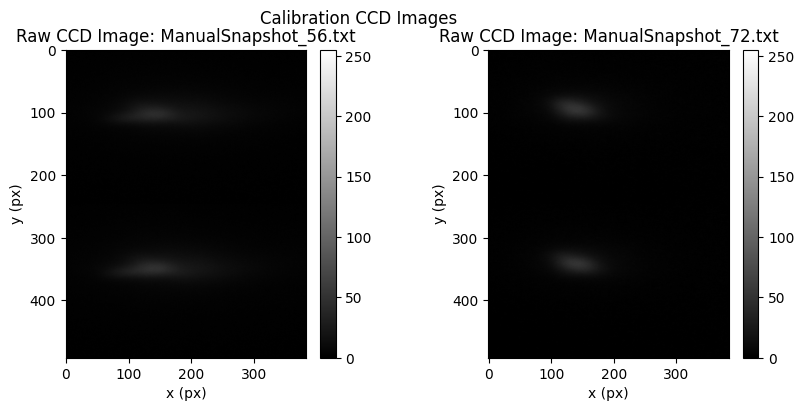

In [13]:
# --- Calibration usage pattern (fill in your own filenames + PD-derived atom numbers)

calib_files = ["ManualSnapshot_72.txt", "ManualSnapshot_56.txt"]
N_from_pd   = np.array([75922380.036776, 4090091952.490676])  # from your voltage notebook for those SAME shots

calib = calibrate_camera_to_pd(calib_files, N_from_pd, region="after_shutter", assume_intercept_zero=True)
print(f"alpha = {calib['alpha']:.3e} atoms / (camera-integral unit)")
display(calib["points"])

# Convert a new image:
out_new = get_params("drop4photo1.txt", show_raw=False, show_split=False, make_fit_plots=False)
S_new = gaussian_integral_from_fitdict(out_new["regions"]["after_shutter"]["fit_dict"])
N_est = camera_to_atoms(S_new, calib["alpha"], calib["beta"])

print('')
print("Estimated atom number from camera:", N_est)

singleshot = np.loadtxt("ManualSnapshot_56.txt", dtype=np.uint8, delimiter=None, skiprows=3)
singleshot2 = np.loadtxt("ManualSnapshot_72.txt", dtype=np.uint8, delimiter=None, skiprows=3)

print(singleshot.shape)

fig, ax = plt.subplots(1,2, figsize=(10, 4))

h = ax[0].imshow(singleshot, cmap="gray", vmin=0, vmax=255)
plt.colorbar(h, fraction=0.046, pad=0.04)
ax[0].set_title(f"Raw CCD Image: ManualSnapshot_56.txt")
ax[0].set_xlabel("x (px)")
ax[0].set_ylabel("y (px)")

h1 = ax[1].imshow(singleshot2, cmap="gray", vmin=0, vmax=255)
plt.colorbar(h1, fraction=0.046, pad=0.04)
ax[1].set_title(f"Raw CCD Image: ManualSnapshot_72.txt")
ax[1].set_xlabel("x (px)")
ax[1].set_ylabel("y (px)")

plt.suptitle("Calibration CCD Images")


plt.show()


In [47]:
# --- Absolute atom number ---

# Constants/Measured Inputs 
DIST_MM = 14.5      # distance from MOT to focusing lens [mm]
DIAM_MM = 5.5       # diameter of focusing lens [mm]
DETUNING_MHZ = 25   # detuning (MHz)
GAMMA_RAD_S = 2*np.pi*6.07e6   # Rb D2 natural linewidth (rad/s)
I_SAT = 17.0  # saturation intensity W/m^2  (1.7 mW/cm^2)
OMEGA_MEAN = np.mean([0.008/2, 0.009/2, 0.0092/2, 0.0085/2])  # mean beam radius at MOT (m)
P_X = 0.005426 # power of input beam in X direction (W)
IMPEDANCE_OHM = 1e6 # DAQ analog I/O input impedance (Ohms)
RESPONSIVITY_AW = 0.45 # responsivity of PD3 (A/W)
LAMBDA = 780e-9


Delta_rad_s = DETUNING_MHZ *1e6*2*np.pi


# indexes
V_ROOM_BOUND = 0.06
V_ZOOMED = 1600
SWITCH_TIME_DELAY = 25
LOADING_WINDOW_UP_BOUND = None

# intensity at MOT
def Ix_MOT(Px):
    Ix = 2*Px/(np.pi*OMEGA_MEAN**2)
    return Ix

# scattering rate calculation
def scattering_rate(Px):
    I = Ix_MOT(Px)
    s = I / I_SAT

    frac = s / (1 + s + (2*Delta_rad_s/GAMMA_RAD_S)**2)
    R_sc = (GAMMA_RAD_S/2) * frac

    print(f"Beam radius w = {OMEGA_MEAN*1e3:.2f} mm")
    print(f"Intensity at MOT = {I:.2f} W/m^2 = {I/10:.2f} mW/cm^2")
    print(f"Saturation parameter s = {s:.2f}")
    print(f"Scattering rate R_sc = {R_sc:.2e} s^-1")
    print(f"Maximum possible (Γ/2) = {GAMMA_RAD_S/2:.2e} s^-1")

    return R_sc, s

def solid_angle():
    # ---- compute solid angle ----
    a = 2.75e-3   # m  (use lens clear aperture radius if you know it)
    d = 0.32      # m  (camera lens distance to MOT)
    Omega = np.pi * a**2 / d**2
    eta_geom = Omega / (4*np.pi)

    print(f"Lens radius a = {a:.3f} m")
    print(f"Distance d    = {d:.3f} m")

    print(f"Solid angle Ω = {Omega:.6f} sr")
    print(f"Collected fraction Ω/4π = {eta_geom:.6%}")
    return Omega

QE_780 = 0.8            # estimated from Sony interline CCDs
gain_e_per_ADU = 4.0    # MUST be measured or treated as systematic
T_opt = 0.8             # lenses + windows + filter
eta_geom = solid_angle()      # from your solid-angle calculation
t_exp = 10e-3           # exposure time [s]

# Scattering rate
# Gamma = 2*np.pi*6.07e6
# s0 = 0.5
# Delta = -2*np.pi*12e6
# R_sc = (Gamma/2) * (s0 / (1 + s0 + (2*Delta/Gamma)**2))

R_sc, _ = scattering_rate(P_X)

# S_ADU = gaussian_integral_from_fitdict(fit_dict)

S_ADU = np.sum(pixarray)

N_atoms = (
    S_ADU * gain_e_per_ADU
    / (QE_780 * eta_geom * T_opt * R_sc * t_exp)
)


print(f"Estimated atom number: N ≈ {N_atoms:.2e}")


Lens radius a = 0.003 m
Distance d    = 0.320 m
Solid angle Ω = 0.000232 sr
Collected fraction Ω/4π = 0.001846%
Beam radius w = 4.34 mm
Intensity at MOT = 183.60 W/m^2 = 18.36 mW/cm^2
Saturation parameter s = 10.80
Scattering rate R_sc = 2.59e+06 s^-1
Maximum possible (Γ/2) = 1.91e+07 s^-1
Estimated atom number: N ≈ 6.99e+05


In [37]:
region = out["regions"]["after_shutter"]
fit_dict = region["fit_dict"]

img = load_ccd_txt('drop4photo1.txt')  # raw ADU image
B = float(fit_dict["Offset_Value"])  # background level in ADU (if fit was on raw ADU)

S_ADU = roi_signal_sum_adu(img, region["roi"], B)

print("S_ADU (sum over ROI) =", S_ADU)


S_ADU (sum over ROI) = 264736.86306402227


In [38]:
print(np.sum(pixarray))

670654


In [42]:

eta_cam = 1.846e-5
QE = 0.4
T_opt = 1.0
R_sc = 2.59e6
gain_e_per_ADU = 1.0

def Natoms_from_N(N):
    texp = (1 + N) * 20e-6
    return (S_ADU * gain_e_per_ADU) / (QE * eta_cam * T_opt * R_sc * texp)

for N in [0, 9, 49, 99, 499, 999, 1999, 4999]:
    print(N, (1+N)*20e-6, Natoms_from_N(N))


0 2e-05 1753384130.1446934
9 0.0002 175338413.01446936
49 0.001 35067682.602893874
99 0.002 17533841.301446937
499 0.01 3506768.2602893873
999 0.02 1753384.1301446937
1999 0.04 876692.0650723468
4999 0.1 350676.8260289387


In [48]:
print("=== Absolute atom number (Route B) ===")
print(f"S_ADU = {S_ADU:.3e}")
print(f"Omega/4pi = {eta_cam:.3e}")
print(f"R_sc = {R_sc:.3e} s^-1")
print()
print("N = K / t_exp, where")
K = (S_ADU * gain_e_per_ADU) / (QE * eta_cam * T_opt * R_sc)
print(f"K = {K:.3e} atoms·s")

for t_ms in [0.5, 1, 2, 5, 10]:
    print(f"t_exp = {t_ms:4.1f} ms → N ≈ {K/(t_ms*1e-3):.2e}")


=== Absolute atom number (Route B) ===
S_ADU = 6.707e+05
Omega/4pi = 1.846e-05
R_sc = 2.586e+06 s^-1

N = K / t_exp, where
K = 1.756e+05 atoms·s
t_exp =  0.5 ms → N ≈ 3.51e+08
t_exp =  1.0 ms → N ≈ 1.76e+08
t_exp =  2.0 ms → N ≈ 8.78e+07
t_exp =  5.0 ms → N ≈ 3.51e+07
t_exp = 10.0 ms → N ≈ 1.76e+07


In [49]:
img_full = load_ccd_txt('drop4photo1.txt')
print("max ADU:", img_full.max(), "mean ADU:", img_full.mean())


max ADU: 235 mean ADU: 3.549786161924119
